# Intro to Machine Learning Jupyter Notebook

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
file_path = "StormEvents_details-ftp_v1.0_d2024_c20250401.csv.gz" # data

df = pd.read_csv(file_path)

df = df[pd.notna(df['DAMAGE_PROPERTY'])] # keep only rows that are not empty in property damage
df = df[pd.notna(df['BEGIN_LAT'])] # keep only rows that are not empty in property damage

df = df.drop(columns=['CZ_TYPE','CZ_FIPS','EPISODE_ID','EVENT_ID','EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE', 'SOURCE', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
                       'DEATHS_INDIRECT','FLOOD_CAUSE','MONTH_NAME','BEGIN_DAY','BEGIN_TIME','END_DAY','END_TIME','CZ_NAME','WFO','CZ_TIMEZONE','BEGIN_RANGE','BEGIN_DATE_TIME','END_DATE_TIME',
                       'TOR_OTHER_CZ_NAME','TOR_OTHER_CZ_STATE','TOR_OTHER_CZ_FIPS','TOR_OTHER_WFO','END_RANGE','BEGIN_AZIMUTH','END_AZIMUTH','']) # drop columns that are not needed
def convert_damage(value):
    if pd.isna(value):
        return 0  # Handle NaN values
    value = str(value).upper().strip()  # Ensure the value is uppercase and clean
    if value.endswith('K'):  # Thousands
        try:
            return float(value[:-1]) * 1e3
        except ValueError:
            return 0
    # Optionally, handle other cases (e.g., values ending in 'M' for millions) if needed.
    try:
        return float(value)
    except ValueError:
        return 0

df['DAMAGE_PROPERTY'] = df['DAMAGE_PROPERTY'].apply(convert_damage)
df['DAMAGE_CROPS'] = df['DAMAGE_CROPS'].apply(convert_damage)

display(df.head(1000))



,BEGIN_YEARMONTH,END_YEARMONTH,STATE,STATE_FIPS,YEAR,EVENT_TYPE,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,MAGNITUDE_TYPE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,BEGIN_LOCATION,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON
2,202405,202405,OKLAHOMA,40,2024,Tornado,150000.0,0.0,NaN,NaN,NaN,EF1,6.7,400.0,CUSTER CITY,CUSTER CITY,35.7100,-99.0010,35.7370,-98.8910
3,202405,202405,OKLAHOMA,40,2024,Thunderstorm Wind,10000.0,0.0,61.00,EG,NaN,NaN,NaN,NaN,NINNEKAH,NINNEKAH,34.9501,-97.9523,34.9501,-97.9523
4,202405,202405,MISSISSIPPI,28,2024,Thunderstorm Wind,1000.0,0.0,52.00,EG,NaN,NaN,NaN,NaN,ALGOMA,ALGOMA,34.1800,-89.0300,34.1800,-89.0300
7,202405,202405,MISSISSIPPI,28,2024,Hail,0.0,0.0,1.00,NaN,NaN,NaN,NaN,NaN,TISHOMINGO CO ARPT,TISHOMINGO CO ARPT,34.5100,-88.2100,34.5100,-88.2100
8,202405,202405,TENNESSEE,47,2024,Hail,0.0,0.0,0.88,NaN,NaN,NaN,NaN,NaN,EUREKA,EUREKA,35.2000,-88.2400,35.2000,-88.2400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010,202407,202407,MASSACHUSETTS,25,2024,Thunderstorm Wind,300.0,0.0,50.00,EG,NaN,NaN,NaN,NaN,WEST CONCORD,WEST CONCORD,42.4600,-71.4300,42.4600,-71.4300
3011,202407,202407,MASSACHUSETTS,25,2024,Thunderstorm Wind,800.0,0.0,50.00,EG,NaN,NaN,NaN,NaN,NORTH CHELMSFORD,NORTH CHELMSFORD,42.6300,-71.3900,42.6300,-71.3900
3012,202407,202407,MASSACHUSETTS,25,2024,Thunderstorm Wind,800.0,0.0,50.00,EG,NaN,NaN,NaN,NaN,FORGE VLG,FORGE VLG,42.5700,-71.5000,42.5700,-71.5000
3013,202407,202407,MASSACHUSETTS,25,2024,Hail,0.0,0.0,0.75,NaN,NaN,NaN,NaN,NaN,PLAINFIELD,PLAINFIELD,42.5200,-72.9200,42.5200,-72.9200


# Feature Engineering


In [60]:


df['DAMAGE_PROPERTY'] = pd.to_numeric(df['DAMAGE_PROPERTY'], errors='coerce')

bins = [0,10000,100000, np.inf]
labels = ['low', 'medium', 'high']
df['DAMAGE_CATEGORY'] = pd.cut(df['DAMAGE_PROPERTY'], bins=bins, labels=labels)
numeric_columns = df.select_dtypes(include=[np.number]).columns

X = df[numeric_columns].drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS']).values
y = df['DAMAGE_CATEGORY'].values
print('The data before feature engineering has as shape of', X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


The data before feature engineering has as shape of (12254, 12)


Accuracy: 0.7564259485924113
Classification Report:
               precision    recall  f1-score   support

        high       0.37      0.47      0.42       118
         low       0.87      0.86      0.86      1797
      medium       0.49      0.47      0.48       536

    accuracy                           0.76      2451
   macro avg       0.58      0.60      0.59      2451
weighted avg       0.76      0.76      0.76      2451



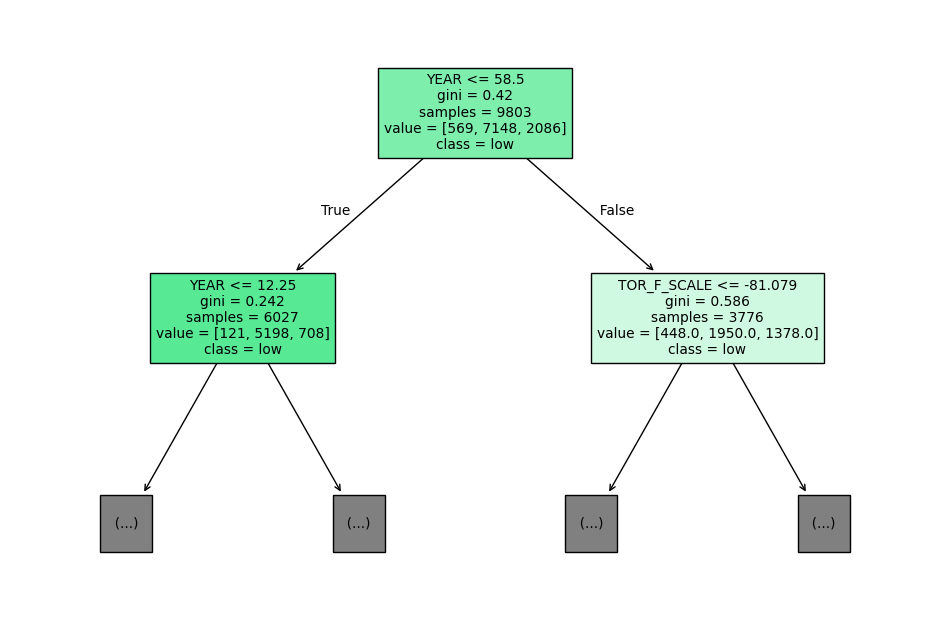

In [67]:
from sklearn.tree import plot_tree


clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 6: Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=df.drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'DAMAGE_CATEGORY']).columns, 
          class_names=clf.classes_, filled=True, max_depth=1)
plt.show()


# Clustering

# Most association with different features